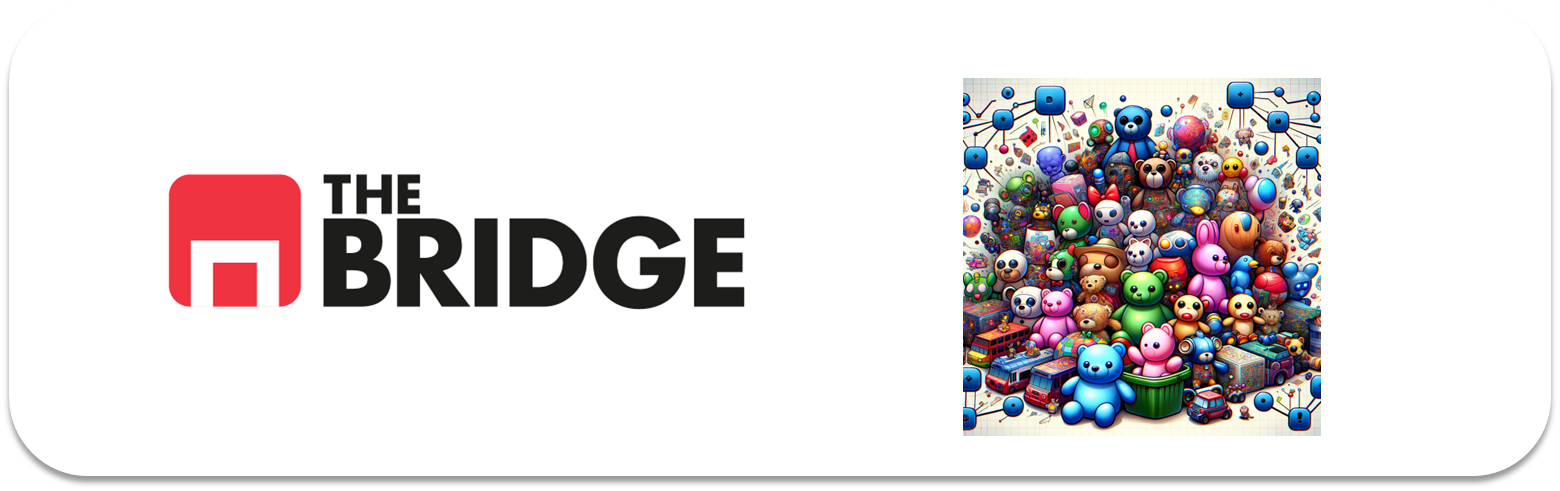

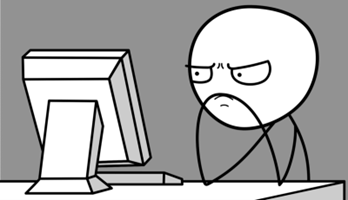

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [3]:

from sklearn.datasets import fetch_olivetti_faces
olivetti = fetch_olivetti_faces()


print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [4]:

olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)

data = pd.DataFrame(data=np.c_[olivetti.data, olivetti.target], columns=[f'pixel_{i}' for i in range(4096)] + ['target'])

print(data.head())

#Dataframe de manera aleatroia 
randomized_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

#Mostramos
print(randomized_data.head())

    pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5   pixel_6  \
0  0.198347  0.235537  0.351240  0.409091  0.421488  0.429752  0.500000   
1  0.185950  0.128099  0.115702  0.132231  0.185950  0.268595  0.433884   
2  0.508264  0.603306  0.619835  0.628099  0.657025  0.665289  0.690083   
3  0.136364  0.140496  0.185950  0.280992  0.318182  0.363636  0.409091   
4  0.652893  0.644628  0.652893  0.706612  0.714876  0.719008  0.743802   

    pixel_7   pixel_8   pixel_9  ...  pixel_4087  pixel_4088  pixel_4089  \
0  0.528926  0.524793  0.553719  ...    0.508264    0.524793    0.504132   
1  0.541322  0.570248  0.586777  ...    0.396694    0.409091    0.301653   
2  0.727273  0.743802  0.768595  ...    0.301653    0.305785    0.314050   
3  0.417355  0.438017  0.454545  ...    0.169421    0.206612    0.276859   
4  0.747934  0.747934  0.756198  ...    0.074380    0.074380    0.082645   

   pixel_4090  pixel_4091  pixel_4092  pixel_4093  pixel_4094  pixel_4095  \
0    0.483471  

In [5]:
#Mostramos el target#
print(data.target)

0      20.0
1      28.0
2       3.0
3      21.0
4       9.0
       ... 
395     7.0
396    10.0
397    27.0
398    34.0
399    10.0
Name: target, Length: 400, dtype: float64


### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [18]:
from sklearn.model_selection import train_test_split

#Dividimos 90-10 
olivetti_train_temp, olivetti_test = train_test_split(data, test_size=0.10, stratify=data['target'], random_state=42)

#Dividimos 89-11
olivetti_train, olivetti_val = train_test_split(olivetti_train_temp, test_size=0.11, stratify=olivetti_train_temp['target'], random_state=42)

# Mostrar las dimensiones de los conjuntos resultantes
print("Dimension train:", olivetti_train.shape)
print("Dimension validación:", olivetti_val.shape)
print("Dimension test:", olivetti_test.shape)

Dimension train: (320, 4097)
Dimension validación: (40, 4097)
Dimension test: (40, 4097)


### #1.4

Crea los pares X,y para train, validation y test.

In [7]:
#TRAIN
X_train = olivetti_train.drop(columns=['target']).values
y_train = olivetti_train['target'].values

#VALIDACION
X_val = olivetti_val.drop(columns=['target']).values
y_val = olivetti_val['target'].values

#TEST
X_test = olivetti_test.drop(columns=['target']).values
y_test = olivetti_test['target'].values

Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [8]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

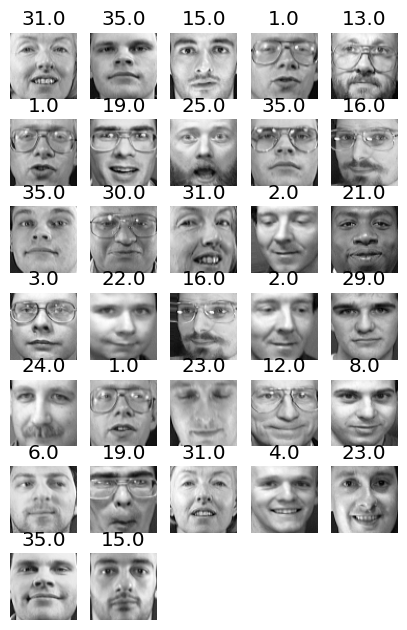

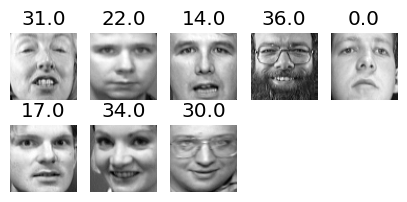

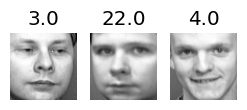

In [9]:
#TRAIN
plot_faces(X_train[::10], y_train[::10])

#VALIDACION
plot_faces(X_val[::5], y_val[::5])

#TEST
plot_faces(X_test[::15], y_test[::15])

### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

pca.n_components_

221

### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

In [19]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []

k_values = range(5, 151, 5)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_pca)
    silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

best_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Mostrar el mejor valor de k y su score de silueta
print(f"Mejor valor de k: {best_k}")
print(f"Score: {max(silhouette_scores)}")


c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Mejor valor de k: 130
Score: 0.20203259990928593


MEJOR VALOR DE K = 130 / SCORE = 0.2020

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

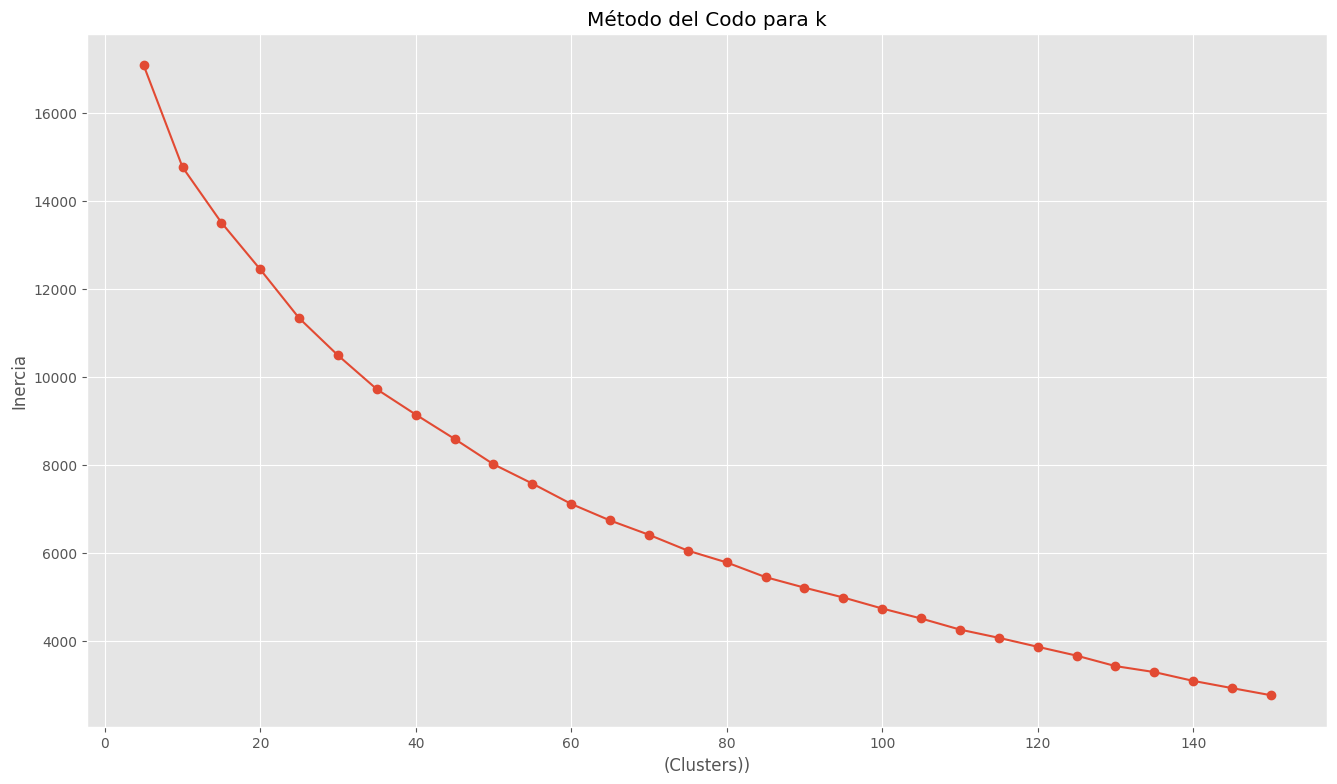

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


inertia_values = []

k_values = range(5, 151, 5)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('(Clusters))')
plt.ylabel('Inercia')
plt.title('Método del Codo para k')
plt.show()

### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [21]:
# K SILUETA
best_k_model = KMeans(n_clusters=best_k, random_state=42)

best_model = best_k_model.fit(X_train_pca)

c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

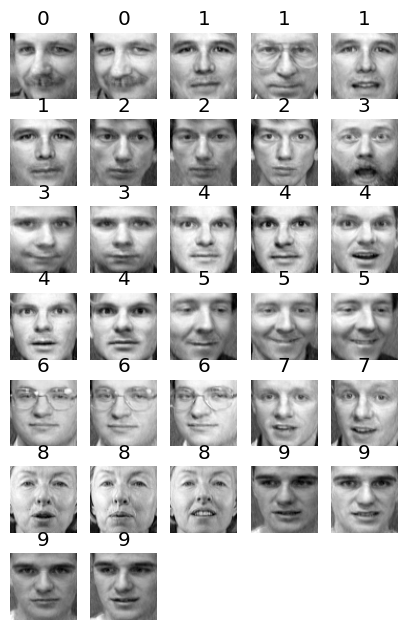

In [14]:
# Transformar las características originales utilizando el modelo PCA
X_train_original = pca.inverse_transform(X_train_pca)

# Función para visualizar las caras asignadas a los primeros 10 clústeres
def visualize_cluster_faces(model, features, original_features, n_clusters=10, n_faces=5):
    cluster_labels = model.labels_

    # Seleccionar las primeras n_clusters caras de cada clúster
    selected_faces = []
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0][:n_faces]
        selected_faces.extend(cluster_indices)

    # Mostrar las caras seleccionadas
    plot_faces(original_features[selected_faces], cluster_labels[selected_faces], n_cols=n_faces)

# Visualizar las caras asignadas a los primeros 10 clústeres
visualize_cluster_faces(best_model, X_train_pca, X_train_original, n_clusters=10, n_faces=5)


## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Crear un clasificador RandomForest con 150 estimadores
random_forest_classifier = RandomForestClassifier(n_estimators=150, random_state=42)

# Separar las características (X) y las etiquetas (y) para los conjuntos de entrenamiento y validación
X_train_rf, y_train_rf = olivetti_train.drop(columns=['target']).values, olivetti_train['target'].values
X_val_rf, y_val_rf = olivetti_val.drop(columns=['target']).values, olivetti_val['target'].values

# Entrenar el clasificador en el conjunto de entrenamiento
random_forest_classifier.fit(X_train_rf, y_train_rf)

# Realizar predicciones en el conjunto de validación
y_val_pred_rf = random_forest_classifier.predict(X_val_rf)

# Calcular la precisión en el conjunto de validación
accuracy_rf = accuracy_score(y_val_rf, y_val_pred_rf)

# Mostrar la precisión del clasificador en el conjunto de validación
print(f"Precisión del clasificador en el conjunto de validación: {accuracy_rf:.2f}")


Precisión del clasificador en el conjunto de validación: 0.97


### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Aplicar el método transform para obtener las distancias a los centroides
X_train_kmeans_distances = best_model.transform(X_train_pca)
X_val_kmeans_distances = best_model.transform(X_valid_pca)
X_test_kmeans_distances = best_model.transform(X_test_pca)

# Crear un clasificador RandomForest con 150 estimadores
random_forest_classifier_kmeans = RandomForestClassifier(n_estimators=150, random_state=42)

# Entrenar el clasificador en el conjunto de entrenamiento reducido por K-Means
random_forest_classifier_kmeans.fit(X_train_kmeans_distances, y_train)

# Realizar predicciones en el conjunto de validación reducido por K-Means
y_val_pred_kmeans = random_forest_classifier_kmeans.predict(X_val_kmeans_distances)

# Calcular la precisión en el conjunto de validación
accuracy_kmeans = accuracy_score(y_val, y_val_pred_kmeans)

# Mostrar la precisión del clasificador en el conjunto de validación
print(f"Precisión del clasificador con K-Means en el conjunto de validación: {accuracy_kmeans:.2f}")


Precisión del clasificador con K-Means en el conjunto de validación: 0.88


PRECISION DEL 0.88 

### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)

In [17]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Lista para almacenar las precisiones para cada valor de k
accuracy_scores = []

# Rango de valores de k a probar (de 5 a 150, por ejemplo)
k_values = range(5, 151, 5)

# Iterar sobre los valores de k y evaluar el rendimiento del clasificador RandomForest
for k in k_values:
    # Crear un modelo K-Means con k clusters
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    
    # Aplicar K-Means para obtener distancias a los centroides
    X_train_kmeans_distances = kmeans_model.fit_transform(X_train_pca)
    X_val_kmeans_distances = kmeans_model.transform(X_valid_pca)
    
    # Crear un clasificador RandomForest con 150 estimadores
    random_forest_classifier_kmeans = RandomForestClassifier(n_estimators=150, random_state=42)
    
    # Entrenar el clasificador en el conjunto de entrenamiento reducido por K-Means
    random_forest_classifier_kmeans.fit(X_train_kmeans_distances, y_train)
    
    # Realizar predicciones en el conjunto de validación reducido por K-Means
    y_val_pred_kmeans = random_forest_classifier_kmeans.predict(X_val_kmeans_distances)
    
    # Calcular la precisión en el conjunto de validación
    accuracy = accuracy_score(y_val, y_val_pred_kmeans)
    
    # Almacenar la precisión para el valor actual de k
    accuracy_scores.append(accuracy)

# Encontrar el valor de k que maximiza la precisión
best_k_kmeans = k_values[accuracy_scores.index(max(accuracy_scores))]

# Mostrar el mejor valor de k y su precisión correspondiente
print(f"Mejor valor de k para K-Means: {best_k_kmeans}")
print(f"Precisión correspondiente: {max(accuracy_scores):.2f}")

c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Mejor valor de k para K-Means: 110
Precisión correspondiente: 0.95


MEJOR VALOR K  = 110 Y PRECISION 0.95